# Hill

## Description

The Hill equation is a parametric dose-response model derived from chemical kinetics. It has a sigmoidal shape when plotting against log-scaled doses. It contains the following parameters

| Parameter | Description |
| --------- | ----------: |
| `E0`      | Effect when $d=0$ |
| `Emax`    | Asymptotic effect as $d \rightarrow \infty$ |
| `C`       | Dose such that $E(d=C) = \frac{E_0 + E_\text{max}}{2}$ |
| `h`       | "Hill coefficient" related to the slope near $d=C$ |

There are two public subclasses of `synergy.single.hill.Hill`

- `Hill_2P`
  - This model does not fit `E0` or `Emax`, but rather expects them to be supplied when the model is instantiated.
- `Hill_CI`
  - This model is a further subclass of `Hill_2P` with `E0=1.0` and `Emax=0.0`. Additionally, it fits the dose-response curve using the linearization method of the median effect equation, rather than via `scipy.optimize.curve_fit()`.

## Assumptions

- The data should follow a sigmoidal shape

If the assumptions are not met, you may consider using a different single-drug model, such as `LogLinear`.

## Hill Example

### Fit the model to data

Dose response models work with 1D arrays of E and drug dose.

#### Specifying parameter bounds

When reasonable bounds on parameters are known, these bounds can be passed into the model. If you struggle to get good fits, constraining parameters into reasonable ranges can often help.

There are a few ways to do this

- Pass bounds for specific parameters: `Hill(E0_bounds=(0.9, 1), h_bounds=(0.5, 2), ...`.
- Pass "generic" bounds for `E`: `Hill(E_bounds=(0, 1), h_bounds=(1e-3, 1e3)`.
  - With generic bounds, both `E0` and `Emax` will be constrained by the given bounds,
- Mix the above: `Hill(E_bounds=(0, 1), E0_bounds=(0.9, 1), ...)`.
  - Specific bounds will always take priority of generic bounds, so this would use `(0.9, 1)` for `E0`, and `(0, 1)` for `Emax`.

By default, `Hill` uses bounds of `(0, inf)` for `h` and `C`, and `(-inf, inf)` for `E` parameters.

For this synthetic dataset, the data was generated such that E ranges from 0 to 1 (+/- noise, but we can assume all E params should be in that range). So we can pass `E_bounds=(0, 1)` when we instatiate the model.

In [1]:
import numpy as np

from synergy import datasets
from synergy.single import Hill

np.random.seed(1234)  # deterministic confidence intervals

d, E = datasets.load_hill_example()
model = Hill(E_bounds=(-0.1, 1.1))
model.fit(d, E, bootstrap_iterations=100)  # bootstrap_iterations is used to estimate confidence intervals

### Plot the model fit

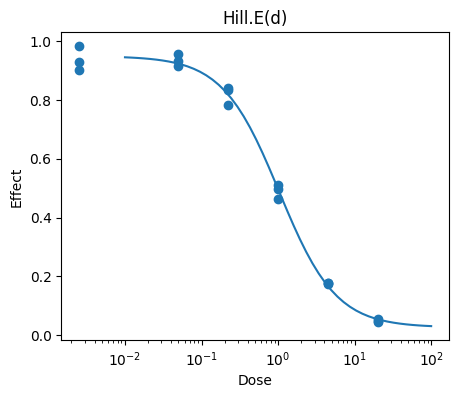

In [2]:
from matplotlib import pyplot as plt

from synergy.utils import remove_zeros

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(remove_zeros(d, num_dilutions=2), E)

# This is used as the x-axis values for model.E(d), to give a smooth curve
d_smooth = np.logspace(-2, 2)
ax.plot(d_smooth, model.E(d_smooth))
ax.set_xscale("log")
ax.set_xlabel("Dose")
ax.set_ylabel("Effect")
ax.set_title("Hill.E(d)")
plt.show()

### Check model fit quality

All parametric models automatically calculate quality-of-fit scores.

In [3]:
print(f"Is fit: {model.is_fit}")  # True if model.fit() was run
print(f"Fit converged: {model.is_converged}")  # True if the model fit successfully converged
print(f"Is fully specified: {model.is_specified}")  # True if all parameters are set (required to call model.E())
print()
print("Fit Quality Stats")
print(f"  Sum of squares residuals: {model.sum_of_squares_residuals}")
print(f"  R^2: {model.r_squared}")
print(f"  AIC: {model.aic}")
print(f"  BIC: {model.bic}")

Is fit: True
Fit converged: True
Is fully specified: True

Fit Quality Stats
  Sum of squares residuals: 0.008834185033397293
  R^2: 0.996153655058854
  AIC: -124.07404413296418
  BIC: -122.69910842040643


### Get all model parameters and confidence intervals

In [4]:
print("Parameters")
print(model.get_parameters())
print()

print("Confidence Interval (95%)")
print(model.get_confidence_intervals())
print()

print("Confidence Interval (50%)")
print(model.get_confidence_intervals(confidence_interval=50))
print()

Parameters
{'E0': 0.9486656324539504, 'Emax': 0.02687061853180388, 'h': 1.1734807393913014, 'C': 1.034970209440454}

Confidence Interval (95%)
{'E0': array([0.92956039, 0.97436566]), 'Emax': array([-0.00384545,  0.06494899]), 'h': array([1.03013288, 1.35836766]), 'C': array([0.92052359, 1.16038919])}

Confidence Interval (50%)
{'E0': array([0.94089162, 0.95468789]), 'Emax': array([0.0181467 , 0.04309284]), 'h': array([1.12620809, 1.2573561 ]), 'C': array([0.98274748, 1.07777016])}



## Hill_2P Example

In [5]:
from synergy.single import Hill_2P

np.random.seed(1234)  # deterministic confidence intervals

d, E = datasets.load_hill_example()
model_2p = Hill_2P(E0=1.0, Emax=0.0)
model_2p.fit(d, E, bootstrap_iterations=100)

### Plot and analyze Hill_2P fit

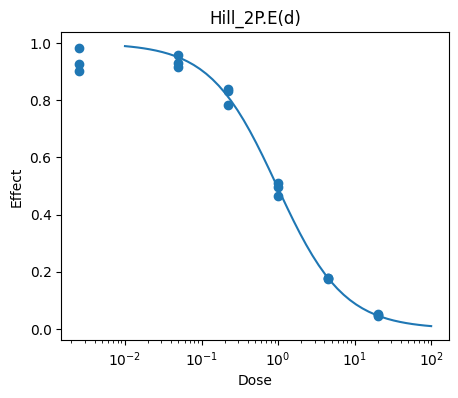


===

Model Fit Scores
Is fit: True
Fit converged: True
Is fully specified: True

Fit Quality Stats
  Sum of squares residuals: 0.02024364996923748
  R^2: 0.9911860505122833
  AIC: -115.42514573683924
  BIC: -113.55403046315075

===

Model Parameters
Parameters
{'h': 0.9954835060681304, 'C': 0.9678777475974989}

Confidence Interval (95%)
{'h': array([0.90821956, 1.11325105]), 'C': array([0.87306605, 1.0633984 ])}

Confidence Interval (50%)
{'h': array([0.95776381, 1.04535511]), 'C': array([0.93218408, 1.01349353])}



In [6]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(remove_zeros(d, num_dilutions=2), E)

# This is used as the x-axis values for model.E(d), to give a smooth curve
d_smooth = np.logspace(-2, 2)
ax.plot(d_smooth, model_2p.E(d_smooth))
ax.set_xscale("log")
ax.set_xlabel("Dose")
ax.set_ylabel("Effect")
ax.set_title("Hill_2P.E(d)")
plt.show()

print("\n===\n")
print("Model Fit Scores")

print(f"Is fit: {model_2p.is_fit}")  # True if model.fit() was run
print(f"Fit converged: {model_2p.is_converged}")  # True if the model fit successfully converged
print(f"Is fully specified: {model_2p.is_specified}")  # True if all parameters are set (required to call model.E())
print()
print("Fit Quality Stats")
print(f"  Sum of squares residuals: {model_2p.sum_of_squares_residuals}")
print(f"  R^2: {model_2p.r_squared}")
print(f"  AIC: {model_2p.aic}")
print(f"  BIC: {model_2p.bic}")

print("\n===\n")
print("Model Parameters")

print("Parameters")
print(model_2p.get_parameters())
print()

print("Confidence Interval (95%)")
print(model_2p.get_confidence_intervals())
print()

print("Confidence Interval (50%)")
print(model_2p.get_confidence_intervals(confidence_interval=50))
print()

## Hill_CI Example

In [7]:
from synergy.single import Hill_CI

d, E = datasets.load_hill_example()
model_ci = Hill_CI()  # parameter bounds are not yet supported for Hill_CI
model_ci.fit(d, E)  # confidence intervals are not yet supported for Hill_CI

### Plot and analyze Hill_CI fit

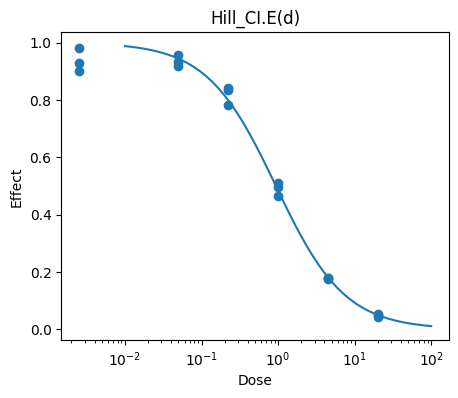


===

Model Fit Scores
Is fit: True
Fit converged: True
Is fully specified: True

Fit Quality Stats
  Sum of squares residuals: 0.02105340328571227
  R^2: 0.9908334893466948
  AIC: -114.71916664367039
  BIC: -112.8480513699819

===

Model Parameters
Parameters
{'h': 0.9627465059253871, 'C': 0.9361750189247218}



In [8]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(remove_zeros(d, num_dilutions=2), E)

# This is used as the x-axis values for model.E(d), to give a smooth curve
d_smooth = np.logspace(-2, 2)
ax.plot(d_smooth, model_ci.E(d_smooth))
ax.set_xscale("log")
ax.set_xlabel("Dose")
ax.set_ylabel("Effect")
ax.set_title("Hill_CI.E(d)")
plt.show()

print("\n===\n")
print("Model Fit Scores")

print(f"Is fit: {model_ci.is_fit}")  # True if model.fit() was run
print(f"Fit converged: {model_ci.is_converged}")  # True if the model fit successfully converged
print(f"Is fully specified: {model_ci.is_specified}")  # True if all parameters are set (required to call model.E())
print()
print("Fit Quality Stats")
print(f"  Sum of squares residuals: {model_ci.sum_of_squares_residuals}")
print(f"  R^2: {model_ci.r_squared}")
print(f"  AIC: {model_ci.aic}")
print(f"  BIC: {model_ci.bic}")

print("\n===\n")
print("Model Parameters")

print("Parameters")
print(model_ci.get_parameters())
print()

## References

Chou, Ting‐Chao, and Paul TaLaLay. "Generalized equations for the analysis of inhibitions of Michaelis‐Menten and higher‐order kinetic systems with two or more mutually exclusive and nonexclusive inhibitors." European journal of biochemistry 115.1 (1981): 207-216.